# Seminar: Starter Notebook
This notebook helps you quickly use your DataLoading (and optionally DataGraphing) classes in Jupyter.

👉 Flow: Install → Paths → config.py → (optional) Credentials → Loader demos

## 0. inital settings

In [57]:
%pip install -q pandas numpy plotly kaleido yfinance fredapi ecbdata requests

Note: you may need to restart the kernel to use updated packages.


In [58]:
# Notebook is located at <PROJECT_ROOT>/notebooks/
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve().parent        # one level up from /notebooks
SRC_ROOT = PROJECT_ROOT / "src"                   # parent of 'seminar_code'
sys.path.insert(0, str(SRC_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT, "exists:", SRC_ROOT.exists())


PROJECT_ROOT: C:\Users\josef\Desktop\Seminar
SRC_ROOT: C:\Users\josef\Desktop\Seminar\src exists: True


In [59]:
# --- one-time import (per kernel) ---
from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Instances ready.")

Instances ready.


In [60]:
# --- hot reload after you edited the source files ---
import importlib

import seminar_code.data_loading.data_loader as dl_mod
import seminar_code.data_graphing.data_grapher as dg_mod  # optional

importlib.reload(dl_mod)
importlib.reload(dg_mod)  # optional

from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Modules reloaded and instances created.")


Modules reloaded and instances created.


In [315]:
import io, requests
import pandas as pd
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

from fredapi import Fred
from pathlib import Path
from seminar_code.data_loading.data_loader import DataLoading

## 2. load data

In [233]:
# Set dates
START_DATE = pd.Timestamp("2000-01-01")
END_DATE = pd.Timestamp("2025-01-01")

### 2.1. FRED

In [234]:
# --- FRED only: API key -> (ensure) loader -> fetch series ---
FRED_KEY = "4d07b674a78d08a1f75abfdd9a936bc8 "

# write/update secrets/credentials.json next to your project (one level above /notebooks)
PROJECT_ROOT = Path.cwd().resolve().parent   # assumes this notebook is in /notebooks
SECRETS_DIR  = PROJECT_ROOT / "secrets"
SECRETS_DIR.mkdir(parents=True, exist_ok=True)
CRED_FILE = SECRETS_DIR / "credentials.json"
CRED_FILE.write_text(json.dumps({"FRED_API": FRED_KEY, "US_Bureau_of_Labor_Statistics": ""}, indent=2),
                     encoding="utf-8")

92

In [235]:
# Quck and dirty way to set the API key in the DataLoading instance
from fredapi import Fred
dl = DataLoading()
dl.fred = Fred(api_key=FRED_KEY)

In [236]:
# fetch FRED series
fred_map = {"WTI": "DCOILWTICO", "Brent": "DCOILBRENTEU", "FedFundsRate": "DFF"}
series_dict, meta_dict, lowest = dl.get_fred_data(
    series_dict_mapping=fred_map,
    start_date=START_DATE,
    end_date=END_DATE
)

fred_df = pd.DataFrame(series_dict).astype(float)
fred_df.fillna(method="ffill", inplace=True)

2025-10-07 22:36:46,950 - INFO - Fetching data for variable WTI with series id: (DCOILWTICO) for start date: 2000-01-01 00:00:00 and end date: 2025-01-01 00:00:00


2025-10-07 22:36:48,101 - INFO - Actual start date for loaded data variable: WTI with series id: (DCOILWTICO): 2000-01-03 00:00:00 instead of 2000-01-01 00:00:00
2025-10-07 22:36:48,104 - INFO - Inferred frequency for WTI is B
2025-10-07 22:36:48,104 - INFO - Fetching data for variable Brent with series id: (DCOILBRENTEU) for start date: 2000-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-07 22:36:49,145 - INFO - Actual start date for loaded data variable: Brent with series id: (DCOILBRENTEU): 2000-01-03 00:00:00 instead of 2000-01-01 00:00:00
2025-10-07 22:36:49,146 - INFO - Inferred frequency for Brent is B
2025-10-07 22:36:49,147 - INFO - Fetching data for variable FedFundsRate with series id: (DFF) for start date: 2000-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-07 22:36:50,500 - INFO - Inferred frequency for FedFundsRate is D
2025-10-07 22:36:50,501 - INFO - Lowest (slowest) frequency: D


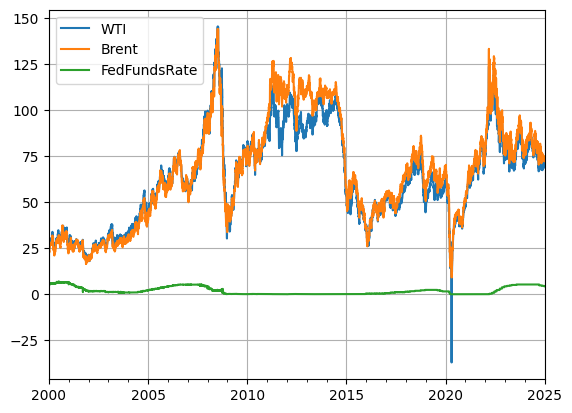

In [237]:
# Simple plot
fred_df['WTI'].plot(label="WTI")
fred_df['Brent'].plot(label="Brent")
fred_df['FedFundsRate'].plot(label="FedFundsRate")

plt.legend()
plt.grid()
plt.show()

### 2.2. BIS - Exchange rate basket

REF_AREA         US
TIME_PERIOD        
2025-09-26   104.07
2025-09-27      NaN
2025-09-28      NaN
2025-09-29   103.66
2025-09-30   103.58


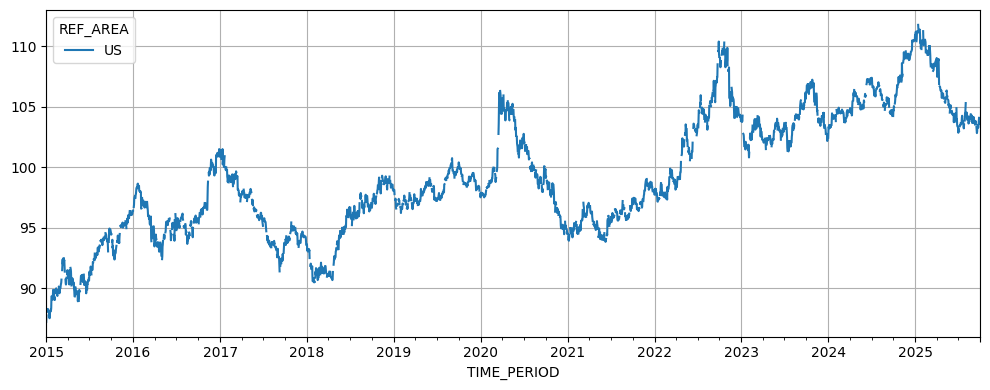

In [67]:
# call BIS API directly (no wrapper available yet)
# see https://www.bis.org/statistics/full_data_sets.htm?m=6%
BASE = "https://stats.bis.org/api/v1/data"
DATASET = "WS_EER"                 # <-- ohne _D !
KEY = "D.N.B.US"                   # D=daily, N=nominal, B=broad, US=US dollar

url = f"{BASE}/{DATASET}/{KEY}"
params = {"format": "csv", "startPeriod": "2015"}  # optional: start/end
r = requests.get(url, params=params, timeout=30)
r.raise_for_status()

# set up DataFrame
bis_df = pd.read_csv(io.StringIO(r.text))
wide = bis_df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")
wide.index = pd.to_datetime(wide.index)
wide.rename(columns={"DE": "Germany NEER (daily, broad)"}, inplace=True)

print(wide.tail())
wide.plot(figsize=(10,4)); plt.grid(True); plt.tight_layout(); plt.show()


### 2.3. yahoo Finance

In [69]:
# Yahoo Finance data
yf_df = dl.get_yahoo_data(
    ticker=["CL=F","NG=F"],                # WTI & NatGas futures
    start_date=START_DATE,
    end_date=END_DATE,
    auto_adjust=False,
    interval="1d"
)

[*********************100%***********************]  2 of 2 completed

FUNCTION: get_yahoo_data


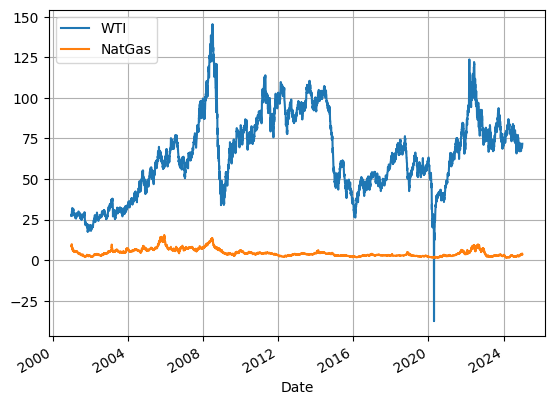

In [70]:
# Simple plot
yf_df['Close']['CL=F'].plot(label="WTI")
yf_df['Close']['NG=F'].plot(label="NatGas")

plt.legend()
plt.grid()
plt.show()

## 2. Markov switch application

Source: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html?utm_source=chatgpt.com
- Didn't find this feature in the scikit learn bib, prob. best to condcut our econometric analysis with stats.
- ...

first dummy example

In [ ]:
import numpy as np
import statsmodels.api as sm

In [ ]:
# Set time index
fred_df.index = pd.to_datetime(fred_df.index)

# Make data stationary
fred_stat_df = np.log(fred_df).pct_change().dropna()

# Define dummy data
wti_data = fred_stat_df['WTI'].loc['2020':]

In [ ]:
# Standardize (helps optimization - otherwise no convergence)
def standardize(series):
    return (series - series.mean()) / series.std()

wti_data = standardize(wti_data)

In [ ]:
# Augmented Dickey-Fuller test
adf_wti = sm.tsa.stattools.adfuller(wti_data)

print("ADF Statistic (WTI):", adf_wti[0], "p-value:", adf_wti[1], "critical_values:", adf_wti[4])

# The data is stationary if the ADF statistic is less than the critical value and the p-value is less than 0.05. 
# So we are good to go for Markov Switching/econmetric modeling..

ADF Statistic (WTI): -8.257339786601388 p-value: 5.19431037294698e-13 critical_values: {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}


- Data is stationary if the ADF statistic is less than the critical value and the p-value is less than 0.05. 
- So we are good to go for Markov Switching/econmetric modeling..

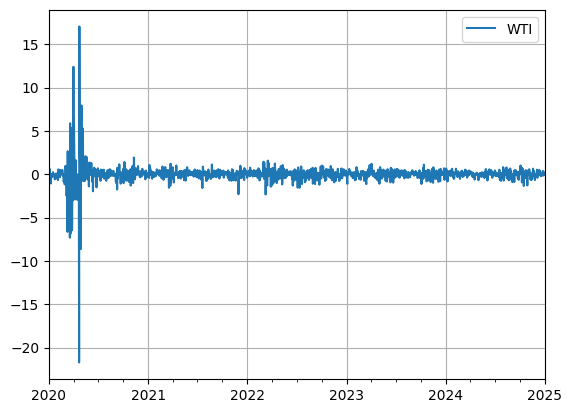

In [200]:
# Visual stationarity check
wti_data.plot(label="WTI")

plt.legend()
plt.grid()
plt.show()

---> Negative values periode might be problematic for log-returns and the model estimation. Will be filtered out in a first step.

In [196]:
# MS model test
mod = sm.tsa.MarkovRegression(
    wti_data,
    k_regimes=2, trend='n', switching_variance=True, freq='D'
    )

wti_res = mod.fit()
print(wti_res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    WTI   No. Observations:                 1828
Model:               MarkovRegression   Log Likelihood               -1071.241
Date:                 Di, 07 Okt 2025   AIC                           2150.482
Time:                        18:53:54   BIC                           2172.526
Sample:                    01-01-2020   HQIC                          2158.613
                         - 01-01-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1187      0.006     20.394      0.000       0.107       0.130
                             Regime 1 parameters    

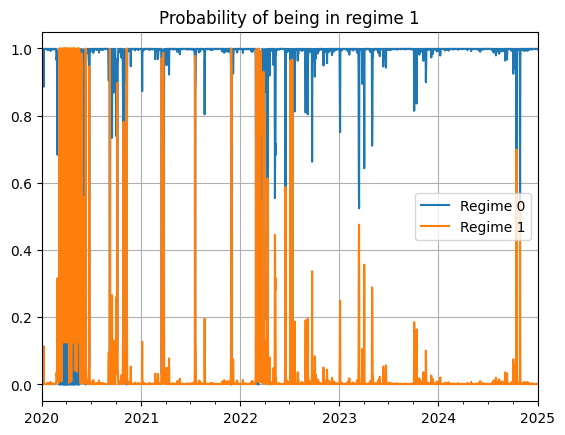

In [198]:
# See probability of being in regime 0 or 1
probs = wti_res.smoothed_marginal_probabilities
probs[0].plot(title="Probability of being in regime 0", label="Regime 0")
probs[1].plot(title="Probability of being in regime 1", label="Regime 1")

plt.legend()
plt.grid()
plt.show()

## 3. First Regression model -- US-FX basket by GAS, Oil, Fed Funds Rate
Idea: Set up a small regression model with:
1. Endogenous variable = NEER Index (narrow basket)
2. Exogenous variables = WTI, BENT, Fed Funds Rate

Method: 
1. Load and merge data to one df.
2. Transform prices to stationary data. --> "log(diff())*100" to get rate of change in percent --> better interpretation later on.
3. Test stationarity, visually and by ADF-test.


In [273]:
# Help functions --
def get_stationary_series(df, rates=None):
    """
    Convert a DataFrame of time series data into stationary series.
    - Preise/Indizes -> log-differenced * 100 (percent changes)
    - Rates (Zinsen) -> simple difference (absolute change)

    Parameters:
    df (pd.DataFrame): Input DataFrame with time series data.
    rates (list): List of column names that should be treated as rates.
                  If None, assumes no rates.

    Returns:
    pd.DataFrame: DataFrame with stationary series.
    """
    if rates is None:
        rates = []

    out = pd.DataFrame(index=df.index)

    for col in df.columns:
        if col in rates:
            out[col] = df[col].diff()
        else:
            out[col] = np.log(df[col]).diff() * 100

    return out.dropna()

def get_standardize(series):
    """
    Standardize a pandas Series.
    
    Parameters:
    series (pd.Series): Input Series to be standardized.
    
    Returns:
    pd.Series: Standardized Series.
    """
    return (series - series.mean()) / series.std()

In [ ]:
# Load NEER data from CSV (downloaded manually from BIS website)
load_csv_df = pd.read_csv("neer_basket_data_01012000.csv", sep=",", skiprows=1, header=1)

load_csv_df.set_index("TIME_PERIOD:Period", inplace=True)
load_csv_df.index = pd.to_datetime(load_csv_df.index)
load_csv_df.rename(columns={"OBS_VALUE:Value": "NEER_USD"}, inplace=True)

# Separate NEER series
neer_df = load_csv_df[["NEER_USD"]].copy()
neer_df.fillna(method="ffill", inplace=True)

In [266]:
# Join all data sources into one DataFrame
all_data = pd.concat([neer_df, fred_df], axis=1)
all_data.dropna(inplace=True)

In [ ]:
# Transform to stationary series
all_stat_df = get_stationary_series(all_data, rates=["FedFundsRate"])

c:\Users\josef\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log



Check for stationarity

In [285]:
# Visual check for stationarity
fig = go.Figure()
for col in all_stat_df.columns:
    fig.add_trace(go.Scatter(x=all_stat_df.index, y=all_stat_df[col], mode='lines', name=col))
fig.update_layout(title="Visual Test for stationarity", xaxis_title="Date", yaxis_title="Value")
fig.show()

In [ ]:
# Check for stationarity - ADF test
for i in all_stat_df.columns:
    print(f"ADF test for {i}:")
    result = sm.tsa.stattools.adfuller(all_stat_df[i])
    print(f"  ADF Statistic: {result[0]}")
    print(f"  p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"  Critical Value ({key}): {value}")
    print()

ADF test for NEER_USD:
  ADF Statistic: -95.5555504817065
  p-value: 0.0
  Critical Value (1%): -3.4310667587457626
  Critical Value (5%): -2.861856761388333
  Critical Value (10%): -2.566938607035052

ADF test for WTI:
  ADF Statistic: -14.700491092983462
  p-value: 2.9519541998853282e-27
  Critical Value (1%): -3.431069519019102
  Critical Value (5%): -2.861857981104369
  Critical Value (10%): -2.566939256295997

ADF test for Brent:
  ADF Statistic: -16.10027519643555
  p-value: 5.140480885783725e-29
  Critical Value (1%): -3.431069281591478
  Critical Value (5%): -2.8618578761893403
  Critical Value (10%): -2.566939200449195

ADF test for FedFundsRate:
  ADF Statistic: -14.97212323159531
  p-value: 1.1958865257415965e-27
  Critical Value (1%): -3.431069519019102
  Critical Value (5%): -2.861857981104369
  Critical Value (10%): -2.566939256295997



Simple econonometric model(s)

In [289]:
# Simmple OLS regression model
y = all_stat_df['NEER_USD']
X = all_stat_df[['WTI', 'Brent', 'FedFundsRate']]
X = sm.add_constant(X)  # add constant term for intercept --> for interpretation of coefficients

ols_model = sm.OLS(y, X).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               NEER_USD   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     69.54
Date:                 Di, 07 Okt 2025   Prob (F-statistic):           1.86e-44
Time:                        23:29:44   Log-Likelihood:                -3086.5
No. Observations:                9127   AIC:                             6181.
Df Residuals:                    9123   BIC:                             6209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0014      0.004      0.407      0.684      -0.006       0.008
WTI             -0.0058      0.002     -2.956      0.003      -0.010      -0.002
Brent           -0.0203      0.002     -9.433      0.000      -0.024      -0.016
FedFundsRate     0.0538      0.054      0.988      0.323      -0.053       0.161
==============================================================================
Omnibus:                     1205.712   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14484.867
Skew:                          -0.143   Prob(JB):                         0.00
Kurtosis:                       9.165   Cond. No.                         42.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results: 
- Overall R^2 very low: Only 2.2% of variance is explained by this model.
- Overall F-statistic is < p-value, so we have significance.
- Only significant variable here is **Oil** --> Evidence to dig deeper on that end + add evidence of oil importance for USD.
- Significance of Oil also cause co-interval belowe 0 for both bounds.

In [308]:
y = all_stat_df['NEER_USD']

# Exogenous variables
X = all_stat_df[['WTI', 'Brent', 'FedFundsRate']]
X.index = y.index   # same index?
X = sm.add_constant(X)

# Markov Switching Model
ms_model = sm.tsa.MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    trend='n',
    switching_variance=False,
    freq='D'
)

ms_res = ms_model.fit()
print(ms_res.summary())

                        Markov Switching Model Results                        
Dep. Variable:               NEER_USD   No. Observations:                 9127
Model:               MarkovRegression   Log Likelihood               -2782.031
Date:                 Mi, 08 Okt 2025   AIC                           5586.062
Time:                        00:06:49   BIC                           5664.371
Sample:                    01-05-2000   HQIC                          5612.690
                         - 01-01-2025                                         
Covariance Type:               approx                                         
                              Regime 0 parameters                               
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0007      0.004     -0.148      0.882      -0.009       0.008
WTI              0.0158      0.002      6.37

In [317]:
probs = ms_res.smoothed_marginal_probabilities
probs_index = probs.index.to_timestamp()


# Output smoothed probabilities in subplots
fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True,
                       subplot_titles=("Smoothed probability of Regime 0", 
                                       "Smoothed probability of Regime 1"))

# Regime 0
fig.add_trace(
    go.Scatter(x=probs_index, y=probs[0], mode='lines', name='Regime 0'),
    row=1, col=1
)

# Regime 1
fig.add_trace(
    go.Scatter(x=probs_index, y=probs[1], mode='lines', name='Regime 1'),
    row=2, col=1
)

fig.update_layout(
    height=600, width=900,
    title="Smoothed Marginal Probabilities of Regimes",
    xaxis_title="Date",
    yaxis_title="Probability"
)

fig.show()

Results:
- Models finds 2 regimes, but only this spec works. --> for more we get the problem of non-convergence.
- BUT clearly we can see the time-varying nature of things with changing mean here.

TRY: Only include Oil as external variable

In [320]:
# New MS model
y = all_stat_df['NEER_USD']
X = all_stat_df[['WTI']]  # only oil as external variable
X.index = y.index   # same index?

ms_oil_model = sm.tsa.MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=3,
    trend='n',
    switching_variance=False,
    freq='D'
)

ms_oil_res = ms_oil_model.fit()
print(ms_oil_res.summary())

                        Markov Switching Model Results                        
Dep. Variable:               NEER_USD   No. Observations:                 9127
Model:               MarkovRegression   Log Likelihood               -2671.441
Date:                 Mi, 08 Okt 2025   AIC                           5362.883
Time:                        00:18:36   BIC                           5434.073
Sample:                    01-05-2000   HQIC                          5387.090
                         - 01-01-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WTI            0.2475      0.015     16.921      0.000       0.219       0.276
                             Regime 1 parameters    